# Machine learning Modelling for Prediction of Diabetes

---

### Import the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#Import libraries

# data anlysis
import numpy as np
import pandas as pd

# data visualization
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# data preparation for modelling
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# model optimization
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, learning_curve
from sklearn.feature_selection import SelectFromModel
from scipy.stats import randint
import itertools
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score

# Artificial Neural Network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Dropout, AlphaDropout
from tensorflow.keras.optimizers import SGD, RMSprop, Adamax, Adagrad, Adam, Nadam, SGD
import eli5
from eli5.sklearn import PermutationImportance

from keras.models import Sequential
from keras.layers.core import Dense
import keras
from keras.optimizers import *
from keras.initializers import *

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

from itertools import chain

# ensure comparability of different runs
np.random.seed(42)

C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


### Load the merged Diabetes Data (diagnostic) and Patients Data 

In [2]:
df_adm = pd.read_csv('data/ADMISSIONS.csv')
df_diab = pd.read_csv('data/df_diag_DIABETIC_NODIABETIC.csv')

new_df = pd.merge(df_diab, df_adm,  how='left', left_on=['SUBJECT_ID','HADM_ID'], right_on = ['SUBJECT_ID','HADM_ID'])
new_df['ADMITTIME'] = pd.to_datetime(new_df['ADMITTIME'])
new_df['DISCHTIME'] = pd.to_datetime(new_df['DISCHTIME'])
new_df['time_admitted'] = (new_df.DISCHTIME-new_df.ADMITTIME).astype('timedelta64[h]')
cols_to_drop = ['Unnamed: 0', 'SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'ICD9_CODE', 'ROW_ID', 'EDREGTIME', 'EDOUTTIME', 'RELIGION', 'DEATHTIME', 'ADMITTIME', 'DISCHTIME', 'LANGUAGE']
new_df.drop(cols_to_drop, axis=1, inplace=True)
new_df.head()

,SHORT_TITLE,LONG_TITLE,Diabetes,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,time_admitted
0,Single lb in-hosp w cs,"Single liveborn, born in hospital, delivered b...",False,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,ASIAN,NEWBORN,0,1,92.0
1,Need prphyl vc vrl hepat,Need for prophylactic vaccination and inoculat...,False,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,ASIAN,NEWBORN,0,1,92.0
2,NB obsrv suspct infect,Observation for suspected infectious condition,False,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,ASIAN,NEWBORN,0,1,92.0
3,Protein-cal malnutr NOS,Unspecified protein-calorie malnutrition,False,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,MARRIED,WHITE,HYPOTENSION,0,1,258.0
4,Cellulitis of leg,"Cellulitis and abscess of leg, except foot",False,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,MARRIED,WHITE,HYPOTENSION,0,1,258.0


### Merge the datasets to create final dataframe

In [3]:
new_df.dropna(inplace=True)
print('Number of Patients with Diabetes : ', new_df[new_df['Diabetes']==False].shape)
print('Number of Patients without Diabetes : ', new_df[new_df['Diabetes']==True].shape)
df_diabetes = new_df[new_df['Diabetes']== True]
df_nondiabetes = new_df[new_df['Diabetes']== False]
df_nondiabetes.dropna(inplace=True)
df_nondiabetes = df_nondiabetes.iloc[:df_diabetes.shape[0], :]
finalDF = df_diabetes.append(df_nondiabetes, ignore_index=True)
print('Number of Final balanced Dataframe : ', finalDF.shape)
# Shuffle and reset index
finalDF = finalDF.sample(frac=1).reset_index(drop=True)
finalDF.head()

Number of Patients with Diabetes :  (552336, 13)
Number of Patients without Diabetes :  (15969, 13)
Number of Final balanced Dataframe :  (31938, 13)


D:\anaconda\envs\dok\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,SHORT_TITLE,LONG_TITLE,Diabetes,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,time_admitted
0,Bacteremia,Bacteremia,False,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,WIDOWED,WHITE,LOWER GI BLEED,0,1,304.0
1,DMII wo cmp nt st uncntr,Diabetes mellitus without mention of complicat...,True,URGENT,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,MARRIED,WHITE,UNSTABLE ANGINA\LFT HEART CATH,0,0,216.0
2,DMI ophth nt st uncntrld,"Diabetes with ophthalmic manifestations, type ...",True,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,MARRIED,WHITE,BOWEL OBSTRUCTION,0,1,726.0
3,Status cardiac pacemaker,Cardiac pacemaker in situ,False,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,MARRIED,BLACK/AFRICAN AMERICAN,PNEUMONIA,0,1,279.0
4,DMII wo cmp nt st uncntr,Diabetes mellitus without mention of complicat...,True,EMERGENCY,CLINIC REFERRAL/PREMATURE,ICF,Medicare,MARRIED,BLACK/AFRICAN AMERICAN,HYPERNATREMIA; UTI; ALTERED MS,0,1,93.0


### Create Features and Label

In [17]:
X = finalDF.drop(['Diabetes'], axis=1)
Y = finalDF['Diabetes']
X_get_dummy = finalDF[['ADMISSION_TYPE', 'INSURANCE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'MARITAL_STATUS']]
X_dummies = pd.get_dummies(X_get_dummy, columns=['ADMISSION_TYPE', 'INSURANCE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'MARITAL_STATUS'], drop_first=True, sparse=True)
X_num = finalDF[['HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA', 'time_admitted']]
X = pd.concat([X_num, X_dummies], axis=1)

In [18]:
print('Shape of Features : ', X.shape)
print('Shape of Labels : ', Y.shape)

Shape of Features :  (31938, 38)
Shape of Labels :  (31938,)


---

# 1. Without UnderSampling

### Split the data into train and test

In [19]:
from sklearn.model_selection import train_test_split
X = X.fillna(lambda x: x.median())
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=30)

# Multiple Machine Learning based on ensemble learning

In [20]:
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [21]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))

kfold = 5
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=None))#4

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())


C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roami

C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roami

D:\anaconda\envs\dok\lib\site-packages\matplotlib\axes\_axes.py:1066: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
D:\anaconda\envs\dok\lib\site-packages\matplotlib\axes\_axes.py:1067: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])


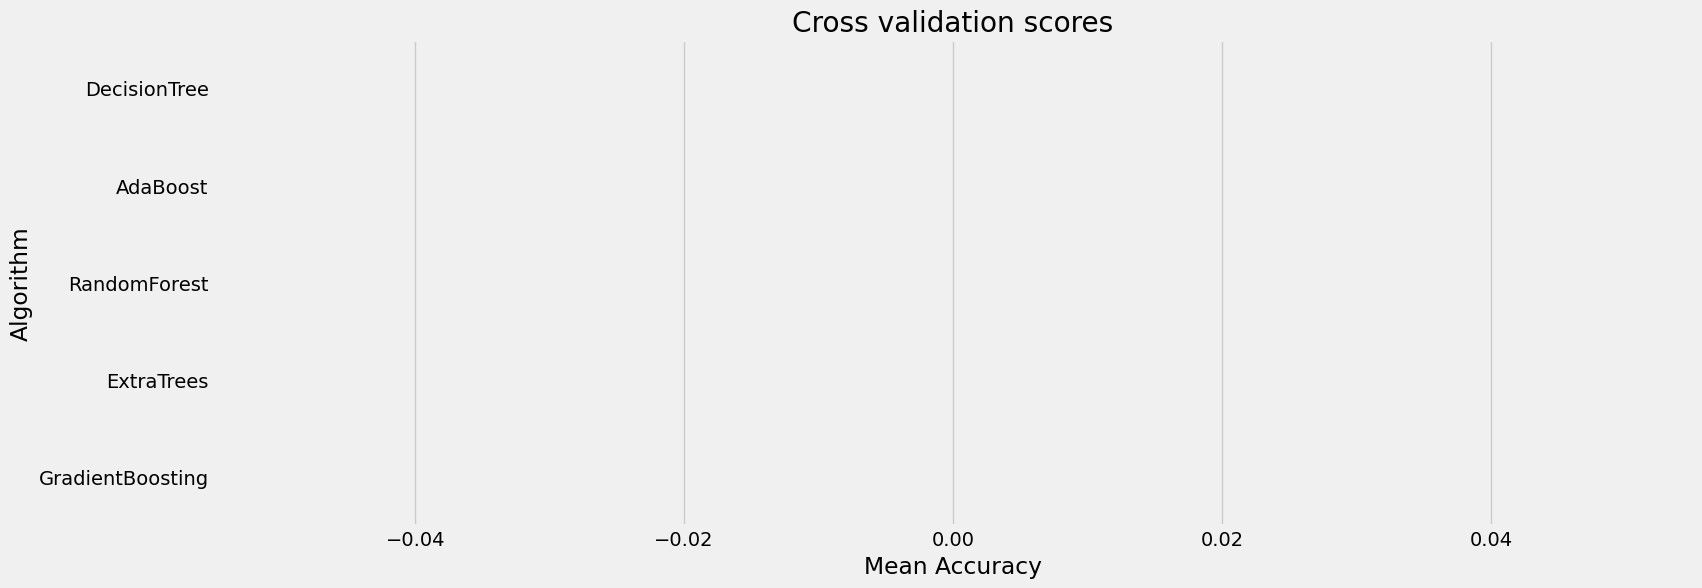

In [46]:
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting"]})
plt.figure(figsize = (17,6))
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [23]:
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.893585,0.004231,DecisionTree
1,0.915459,0.004543,AdaBoost
2,0.896046,0.004023,RandomForest
3,0.904589,0.003482,ExtraTrees
4,0.633432,0.004944,GradientBoosting


## Multiple Models using Grid Search - Model Selection

In [24]:
from sklearn.model_selection import GridSearchCV
class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=3, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [25]:
models = {
    'DecisionTreeClassifier' : DecisionTreeClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
}

params = {
    'DecisionTreeClassifier': { 'max_depth' : [3,5,7,9]},    
    'AdaBoostClassifier':  { 'learning_rate': [0.001, 0.01,0.1] , 'n_estimators': [200, 500]},
    'RandomForestClassifier': { 'max_depth' : [3,5,7,9], 'n_estimators': [200, 500]},
    'ExtraTreesClassifier': { 'max_depth' : [3,5,7,9], 'n_estimators': [200, 500] },
    'GradientBoostingClassifier': { 'max_depth' : [3,5,7,9], 'n_estimators': [200, 500], 'max_features' : ['sqrt', 'auto']  },
}

In [26]:
helper = EstimatorSelectionHelper(models, params)
helper.fit(X, Y, scoring='accuracy', n_jobs=None)#2

Running GridSearchCV for DecisionTreeClassifier.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy ar

C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Running GridSearchCV for AdaBoostClassifier.
Fitting 3 folds for each of 6 candidates, totalling 18 fits


C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roami

C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roami

Running GridSearchCV for RandomForestClassifier.
Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roami

C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roami

C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFr

Running GridSearchCV for ExtraTreesClassifier.
Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roami

C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roami

C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFr

Running GridSearchCV for GradientBoostingClassifier.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roami

C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roami

C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roami

C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roami

C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roami

In [27]:
helper.score_summary(sort_by='max_score')

DecisionTreeClassifier
AdaBoostClassifier
RandomForestClassifier
ExtraTreesClassifier
GradientBoostingClassifier


D:\anaconda\envs\dok\lib\site-packages\ipykernel_launcher.py:49: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,estimator,min_score,mean_score,max_score,std_score,learning_rate,max_depth,max_features,n_estimators
41,GradientBoostingClassifier,0.910952,0.914678,0.917058,0.00266821,NaN,9,auto,500
37,GradientBoostingClassifier,0.874507,0.876104,0.877888,0.00138689,NaN,7,auto,500
39,GradientBoostingClassifier,0.866804,0.870875,0.874319,0.0030996,NaN,9,sqrt,500
40,GradientBoostingClassifier,0.861732,0.866491,0.873943,0.00533642,NaN,9,auto,200
36,GradientBoostingClassifier,0.799361,0.809569,0.81796,0.00770064,NaN,7,auto,200
38,GradientBoostingClassifier,0.797577,0.802774,0.812324,0.00676151,NaN,9,sqrt,200
33,GradientBoostingClassifier,0.787808,0.793037,0.803119,0.00713072,NaN,5,auto,500
35,GradientBoostingClassifier,0.792316,0.79504,0.798892,0.00280016,NaN,7,sqrt,500
32,GradientBoostingClassifier,0.714071,0.723402,0.739339,0.011324,NaN,5,auto,200
34,GradientBoostingClassifier,0.724497,0.730603,0.739245,0.00628198,NaN,7,sqrt,200


### Checking other Metrics

In [28]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
## Final Tuned Model
classifiers = []
classifiers.append(DecisionTreeClassifier(random_state=random_state, max_depth = 9))
classifiers.append(AdaBoostClassifier(learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state,max_depth = 9, n_estimators = 500))
classifiers.append(ExtraTreesClassifier(random_state=random_state, max_depth = 9, n_estimators = 500))
classifiers.append(GradientBoostingClassifier(random_state=random_state, max_depth = 9, n_estimators = 500, max_features = 'auto'))
                   
models = ["DecisionTree","AdaBoost", "RandomForest","ExtraTrees","GradientBoosting"]
train_accuracy = []
test_accuracy = []
precision = []
recall = []
f1 = []


for classifier,model in zip(classifiers, models):
    print('='*len(model))
    print(model)
    print('='*len(model))
    classifier.fit(X_train, y_train)
    trainprediction = classifier.predict(X_train)
    prediction = classifier.predict(X_test)
    trainaccuracy = accuracy_score(y_train, trainprediction)
    testaccuracy = accuracy_score(y_test, prediction)
    train_accuracy.append(trainaccuracy)
    test_accuracy.append(testaccuracy)
    precision.append(precision_score(y_test, prediction))
    recall.append(recall_score(y_test, prediction))
    f1.append(f1_score(y_test, prediction))
    print('Accuracy:', np.round(accuracy_score(y_test, prediction)))
    print('F1 score:', np.round(f1_score(y_test, prediction)))
    print('Recall:', np.round(recall_score(y_test, prediction)))
    print('Precision:', np.round(precision_score(y_test, prediction)))
    print('\n clasification report:\n', classification_report(y_test,prediction))
    print('\n confussion matrix:\n',confusion_matrix(y_test, prediction))
    print('\n')

DecisionTree
Accuracy: 1.0
F1 score: 1.0
Recall: 1.0
Precision: 1.0

 clasification report:
               precision    recall  f1-score   support

       False       0.61      0.76      0.68      4782
        True       0.68      0.53      0.60      4800

    accuracy                           0.64      9582
   macro avg       0.65      0.64      0.64      9582
weighted avg       0.65      0.64      0.64      9582


 confussion matrix:
 [[3617 1165]
 [2273 2527]]


AdaBoost


C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roami

Accuracy: 1.0
F1 score: 1.0
Recall: 0.0
Precision: 1.0

 clasification report:
               precision    recall  f1-score   support

       False       0.56      0.74      0.64      4782
        True       0.62      0.43      0.51      4800

    accuracy                           0.59      9582
   macro avg       0.59      0.59      0.58      9582
weighted avg       0.59      0.59      0.58      9582


 confussion matrix:
 [[3526 1256]
 [2720 2080]]


RandomForest


C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


Accuracy: 1.0
F1 score: 1.0
Recall: 1.0
Precision: 1.0

 clasification report:
               precision    recall  f1-score   support

       False       0.65      0.73      0.69      4782
        True       0.70      0.61      0.65      4800

    accuracy                           0.67      9582
   macro avg       0.67      0.67      0.67      9582
weighted avg       0.67      0.67      0.67      9582


 confussion matrix:
 [[3511 1271]
 [1877 2923]]


ExtraTrees


C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


Accuracy: 1.0
F1 score: 1.0
Recall: 1.0
Precision: 1.0

 clasification report:
               precision    recall  f1-score   support

       False       0.62      0.72      0.67      4782
        True       0.67      0.56      0.61      4800

    accuracy                           0.64      9582
   macro avg       0.65      0.64      0.64      9582
weighted avg       0.65      0.64      0.64      9582


 confussion matrix:
 [[3462 1320]
 [2097 2703]]


GradientBoosting


C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


Accuracy: 1.0
F1 score: 1.0
Recall: 1.0
Precision: 1.0

 clasification report:
               precision    recall  f1-score   support

       False       0.87      0.97      0.92      4782
        True       0.97      0.86      0.91      4800

    accuracy                           0.92      9582
   macro avg       0.92      0.92      0.92      9582
weighted avg       0.92      0.92      0.92      9582


 confussion matrix:
 [[4655  127]
 [ 675 4125]]




In [29]:
scoreDF = pd.DataFrame({'Model' : models})
scoreDF['Train Accuracy'] = train_accuracy
scoreDF['Test Accuracy'] = test_accuracy
scoreDF['Precision'] =  precision
scoreDF['Recall'] =  recall
scoreDF['F1 Score'] = f1 

In [47]:
scoreDF.set_index("Model")

,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score
Model,,,,,
DecisionTree,0.658347,0.641202,0.684453,0.526458,0.595148
AdaBoost,0.590222,0.585055,0.623501,0.433333,0.511308
RandomForest,0.688853,0.671467,0.696948,0.608958,0.649989
ExtraTrees,0.658481,0.643394,0.671887,0.563125,0.612717
GradientBoosting,0.958356,0.916301,0.970132,0.859375,0.911401


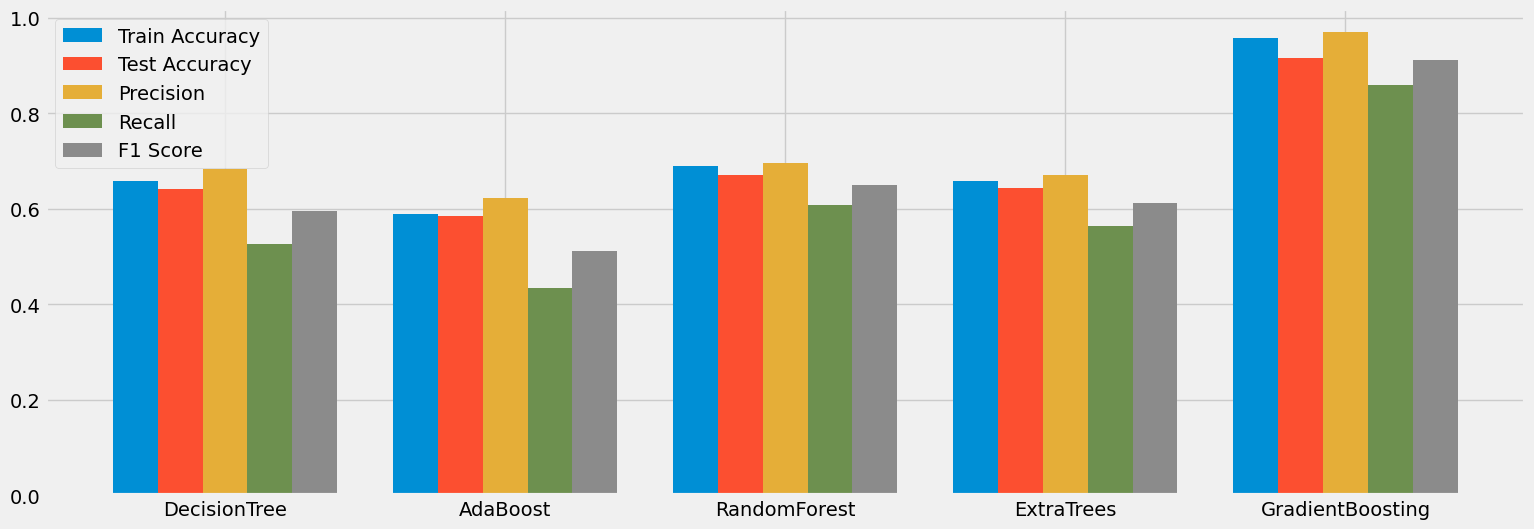

In [48]:
plt.style.use('fivethirtyeight')
def subcategorybar(X, vals, width=0.8):
    cols = ['Train Accuracy', 'Test Accuracy', 'Precision', 'Recall','F1 Score']
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        plt.bar(_X - width/2. + i/float(n)*width, vals[i], width=width/float(n), align="edge")   
        
        
    plt.xticks(_X, X)
    
plt.figure(figsize = (17,6))
subcategorybar(models, [scoreDF['Train Accuracy'], scoreDF['Test Accuracy'], scoreDF['Precision'], scoreDF['Recall'], scoreDF['F1 Score']])
cols = ['Train Accuracy', 'Test Accuracy', 'Precision', 'Recall','F1 Score']
plt.legend(cols)
plt.show()

### Gradient Boosting Classifier is the best classifier

# With UnderSample

In [49]:
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import train_test_split
undersample = TomekLinks()

X = finalDF.drop(['Diabetes'], axis=1)
Y = finalDF['Diabetes']
# transform the dataset
X = pd.concat([X_num, X_dummies], axis=1)
X, Y = undersample.fit_resample(X, Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=30)

C:\Users\Qwert\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


In [50]:
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [51]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))

kfold = 5
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())


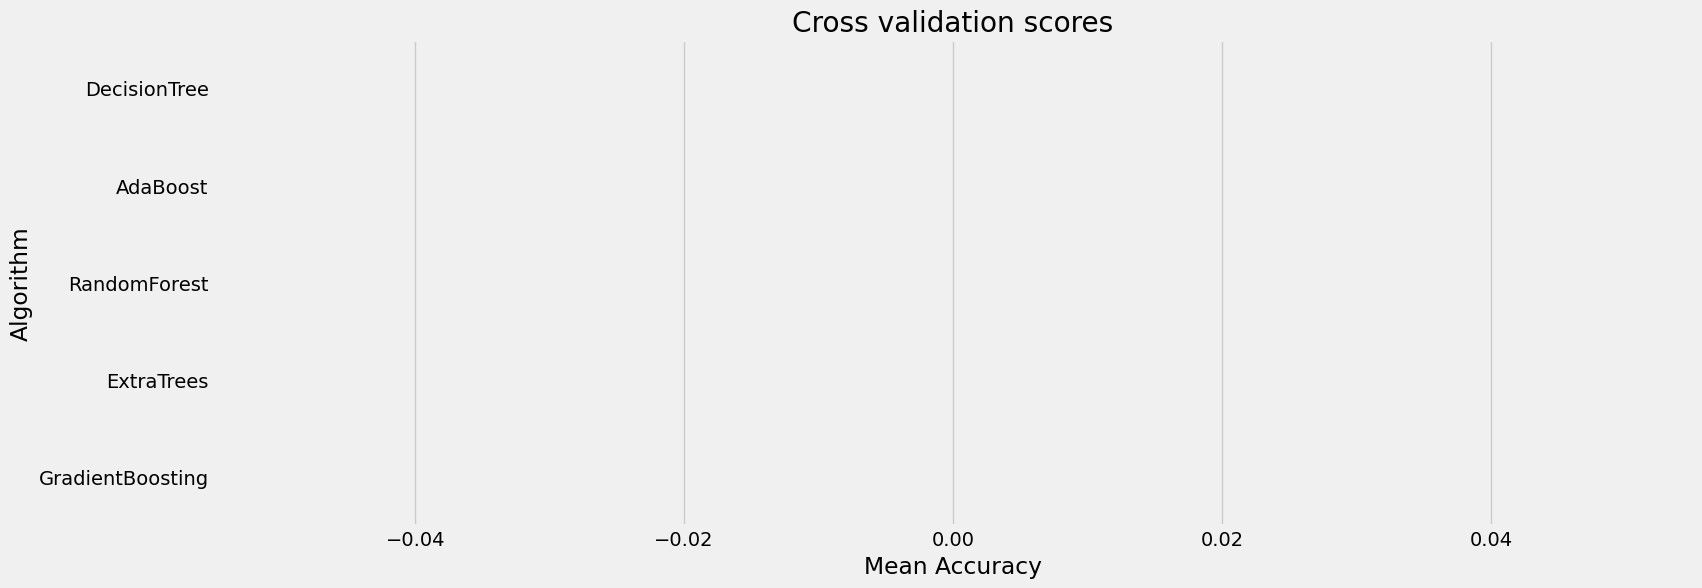

In [55]:
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting"]})
plt.figure(figsize = (17,6))
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [54]:
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,NaN,NaN,DecisionTree
1,NaN,NaN,AdaBoost
2,NaN,NaN,RandomForest
3,NaN,NaN,ExtraTrees
4,NaN,NaN,GradientBoosting


## Multiple Models using Grid Search - Model Selection

In [20]:
from sklearn.model_selection import GridSearchCV
class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=3, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [21]:
models = {
    'DecisionTreeClassifier' : DecisionTreeClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
}

params = {
    'DecisionTreeClassifier': { 'max_depth' : [3,5,7,9]},    
    'AdaBoostClassifier':  { 'learning_rate': [0.001, 0.01,0.1] , 'n_estimators': [200, 500]},
    'RandomForestClassifier': { 'max_depth' : [3,5,7,9], 'n_estimators': [200, 500]},
    'ExtraTreesClassifier': { 'max_depth' : [3,5,7,9], 'n_estimators': [200, 500] },
    'GradientBoostingClassifier': { 'max_depth' : [3,5,7,9], 'n_estimators': [200, 500], 'max_features' : ['sqrt', 'auto']  },
}

In [22]:
helper = EstimatorSelectionHelper(models, params)
helper.fit(X, Y, scoring='accuracy', n_jobs=2)

Running GridSearchCV for DecisionTreeClassifier.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for AdaBoostClassifier.
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 out of  18 | elapsed:  3.0min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for RandomForestClassifier.
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=2)]: Done  24 out of  24 | elapsed:  1.6min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for ExtraTreesClassifier.
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=2)]: Done  24 out of  24 | elapsed:  1.8min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for GradientBoostingClassifier.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=2)]: Done  48 out of  48 | elapsed: 12.5min finished


In [23]:
helper.score_summary(sort_by='max_score')

DecisionTreeClassifier
AdaBoostClassifier
RandomForestClassifier
ExtraTreesClassifier
GradientBoostingClassifier


,estimator,min_score,mean_score,max_score,std_score,max_depth,learning_rate,n_estimators,max_features
41,GradientBoostingClassifier,0.911884,0.914016,0.916111,0.001726,9,NaN,500,auto
37,GradientBoostingClassifier,0.87008,0.875908,0.880143,0.00425985,7,NaN,500,auto
40,GradientBoostingClassifier,0.861719,0.868956,0.877607,0.00656254,9,NaN,200,auto
39,GradientBoostingClassifier,0.868765,0.870366,0.871877,0.00127209,9,NaN,500,sqrt
36,GradientBoostingClassifier,0.802912,0.811529,0.823502,0.00873425,7,NaN,200,auto
38,GradientBoostingClassifier,0.79427,0.802073,0.807985,0.00575673,9,NaN,200,sqrt
33,GradientBoostingClassifier,0.7845,0.791301,0.804152,0.0090921,5,NaN,500,auto
35,GradientBoostingClassifier,0.791639,0.794589,0.799079,0.0032269,7,NaN,500,sqrt
34,GradientBoostingClassifier,0.724847,0.731964,0.739808,0.00612949,7,NaN,200,sqrt
32,GradientBoostingClassifier,0.710005,0.719094,0.734079,0.0106756,5,NaN,200,auto


### Checking other Metrics

In [24]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
## Final Tuned Model
classifiers = []
classifiers.append(DecisionTreeClassifier(random_state=random_state, max_depth = 9))
classifiers.append(AdaBoostClassifier(learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state,max_depth = 9, n_estimators = 500))
classifiers.append(ExtraTreesClassifier(random_state=random_state, max_depth = 9, n_estimators = 500))
classifiers.append(GradientBoostingClassifier(random_state=random_state, max_depth = 9, n_estimators = 500, max_features = 'auto'))
                   
models = ["DecisionTree","AdaBoost", "RandomForest","ExtraTrees","GradientBoosting"]
train_accuracy = []
test_accuracy = []
precision = []
recall = []
f1 = []


for classifier,model in zip(classifiers, models):
    print('='*len(model))
    print(model)
    print('='*len(model))
    classifier.fit(X_train, y_train)
    trainprediction = classifier.predict(X_train)
    prediction = classifier.predict(X_test)
    trainaccuracy = accuracy_score(y_train, trainprediction)
    testaccuracy = accuracy_score(y_test, prediction)
    train_accuracy.append(trainaccuracy)
    test_accuracy.append(testaccuracy)
    precision.append(precision_score(y_test, prediction))
    recall.append(recall_score(y_test, prediction))
    f1.append(f1_score(y_test, prediction))
    print('Accuracy:', np.round(accuracy_score(y_test, prediction)))
    print('F1 score:', np.round(f1_score(y_test, prediction)))
    print('Recall:', np.round(recall_score(y_test, prediction)))
    print('Precision:', np.round(precision_score(y_test, prediction)))
    print('\n clasification report:\n', classification_report(y_test,prediction))
    print('\n confussion matrix:\n',confusion_matrix(y_test, prediction))
    print('\n')

DecisionTree
Accuracy: 1.0
F1 score: 1.0
Recall: 1.0
Precision: 1.0

 clasification report:
               precision    recall  f1-score   support

       False       0.64      0.63      0.64      4768
        True       0.64      0.65      0.65      4813

    accuracy                           0.64      9581
   macro avg       0.64      0.64      0.64      9581
weighted avg       0.64      0.64      0.64      9581


 confussion matrix:
 [[3018 1750]
 [1679 3134]]


AdaBoost
Accuracy: 1.0
F1 score: 1.0
Recall: 0.0
Precision: 1.0

 clasification report:
               precision    recall  f1-score   support

       False       0.56      0.72      0.63      4768
        True       0.62      0.44      0.51      4813

    accuracy                           0.58      9581
   macro avg       0.59      0.58      0.57      9581
weighted avg       0.59      0.58      0.57      9581


 confussion matrix:
 [[3441 1327]
 [2688 2125]]


RandomForest
Accuracy: 1.0
F1 score: 1.0
Recall: 1.0
Precision

In [56]:
scoreDF = pd.DataFrame({'Model' : models})
scoreDF['Train Accuracy'] = train_accuracy
scoreDF['Test Accuracy'] = test_accuracy
scoreDF['Precision'] =  precision
scoreDF['Recall'] =  recall
scoreDF['F1 Score'] = f1 

In [57]:
scoreDF.set_index("Model")

,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score
Model,,,,,
DecisionTree,0.658347,0.641202,0.684453,0.526458,0.595148
AdaBoost,0.590222,0.585055,0.623501,0.433333,0.511308
RandomForest,0.688853,0.671467,0.696948,0.608958,0.649989
ExtraTrees,0.658481,0.643394,0.671887,0.563125,0.612717
GradientBoosting,0.958356,0.916301,0.970132,0.859375,0.911401


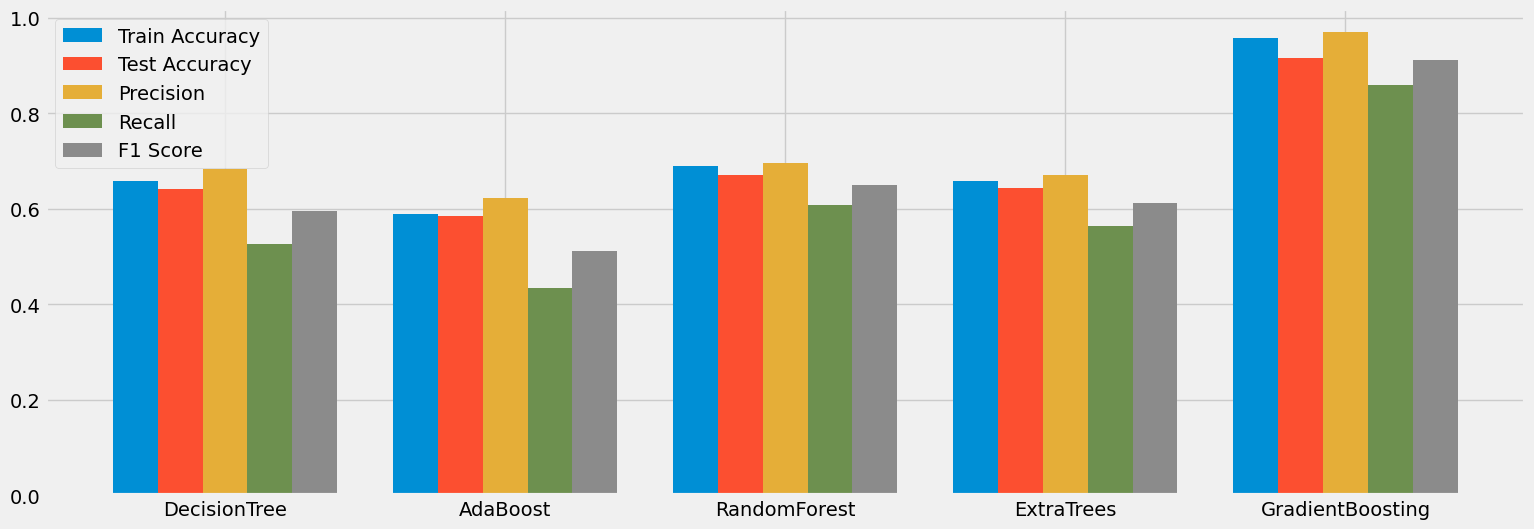

In [58]:
plt.style.use('fivethirtyeight')
def subcategorybar(X, vals, width=0.8):
    cols = ['Train Accuracy', 'Test Accuracy', 'Precision', 'Recall','F1 Score']
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        plt.bar(_X - width/2. + i/float(n)*width, vals[i], width=width/float(n), align="edge")   
        
        
    plt.xticks(_X, X)
    
plt.figure(figsize = (17,6))
subcategorybar(models, [scoreDF['Train Accuracy'], scoreDF['Test Accuracy'], scoreDF['Precision'], scoreDF['Recall'], scoreDF['F1 Score']])
cols = ['Train Accuracy', 'Test Accuracy', 'Precision', 'Recall','F1 Score']
plt.legend(cols)
plt.show()

With Undersampling, results does not change much..